导包

In [34]:
import ipykernel
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model
import keras.backend as K
from keras import layers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import os
os.environ["CUDA_VIDIBLE_DEVICES"] = "0"

定义超参数

In [35]:
batch_size = 256
pretrain_epochs = 10
mlp_epochs = 15
embedding_dim = 128
margin=0.3

定义对比损失函数，triplet_loss

In [36]:
def triplet_loss(margin):
    def loss(y_true, y_pred):
        total_length = y_pred.shape.as_list()[-1]
        anchor = y_pred[:, 0:int(total_length * 1 / 3)]
        positive = y_pred[:, int(total_length * 1 / 3):int(total_length * 2 / 3)]
        negative = y_pred[:, int(total_length * 2 / 3):int(total_length * 3 / 3)]

        # distance between the anchor and the positive
        pos_dist = K.sum(K.square(anchor - positive), axis=1)
        # distance between the anchor and the negative
        neg_dist = K.sum(K.square(anchor - negative), axis=1)

        return K.maximum(pos_dist - neg_dist + margin, 0.0)

    return loss

自定义DataGenerator生成minibatch的样本图片和标签

In [37]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, y, batch_size, num_classes):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.data_aug = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
        )

    def __len__(self):
        return int(np.ceil(len(self.x)) / float(self.batch_size))

    def __getitem__(self, index):
        batch_x = self.x[index * self.batch_size: (index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size: (index + 1) * self.batch_size]
        anchor = batch_x
        positive = self.data_aug.flow(anchor, shuffle=False, batch_size=self.batch_size).next()
        negative = np.zeros_like(anchor)

        for i in range(self.batch_size):
            neg_idx = np.random.choice(np.where(self.y != batch_y[i])[0])
            negative[i] = self.x[neg_idx]

        return [anchor, positive, negative], np.zeros((self.batch_size,))

加载数据集

In [38]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
input_shape = x_train.shape[1:]
num_classes = y_train.shape[-1]

创建预训练模型，开始预训练

In [39]:
def create_base_network(input_shape, output_embedding_dim):
    input1 = layers.Input(input_shape)
    x = layers.Conv2D(32, (3, 3))(input1)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3, 3))(input1)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(output_embedding_dim, activation='relu')(x)
    return Model(input1, x, name='base_network')

base_network = create_base_network(input_shape=input_shape, output_embedding_dim=embedding_dim)
input_a = layers.Input(shape=input_shape, name="input_a")
input_p = layers.Input(shape=input_shape, name="input_p")
input_n = layers.Input(shape=input_shape, name="input_n")
output_a = base_network(input_a)
output_p = base_network(input_p)
output_n = base_network(input_n)
merged_output = layers.concatenate([output_a, output_p, output_n], axis=-1)
pretrain_model = keras.Model(inputs=[input_a, input_p, input_n], outputs=merged_output)

data_generator = DataGenerator(x_train, y_train, batch_size, num_classes)
pretrain_model.compile(loss=triplet_loss(margin=margin), optimizer=Adam())
pretrain_model.fit(data_generator, epochs=pretrain_epochs)


Epoch 1/10
234/234 [==============================] - 33s 136ms/step - loss: 0.7532
Epoch 2/10
234/234 [==============================] - 30s 130ms/step - loss: 0.1135
Epoch 3/10
234/234 [==============================] - 28s 119ms/step - loss: 0.0771
Epoch 4/10
234/234 [==============================] - 28s 120ms/step - loss: 0.0553
Epoch 5/10
234/234 [==============================] - 29s 122ms/step - loss: 0.0402
Epoch 6/10
234/234 [==============================] - 28s 118ms/step - loss: 0.0319
Epoch 7/10
234/234 [==============================] - 28s 119ms/step - loss: 0.0287
Epoch 8/10
234/234 [==============================] - 28s 121ms/step - loss: 0.0235
Epoch 9/10
234/234 [==============================] - 28s 120ms/step - loss: 0.0189
Epoch 10/10
234/234 [==============================] - 28s 120ms/step - loss: 0.0170


tSNE可视化

313/313 [==============================] - 0s 2ms/step


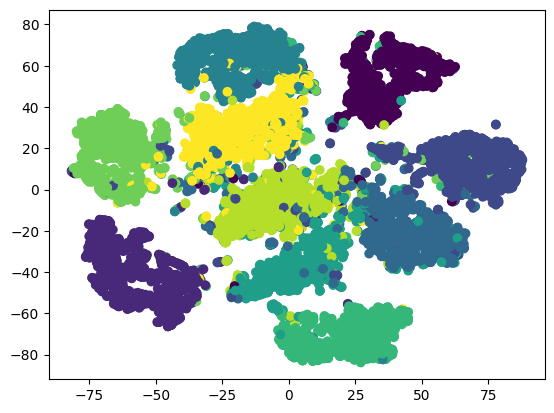

In [41]:
model = pretrain_model.get_layer("base_network")

embeddings = model.predict(x_test)
tsne_embeddings = TSNE(n_components=2).fit_transform(embeddings)

plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=y_test)
plt.show()

创建mlp，训练并评估

In [43]:
mlp_model = keras.Sequential([
    layers.Dense(64, input_shape=(embedding_dim,), name='fc1'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.25),

    layers.Dense(num_classes, activation='softmax', name='fc2')
], name="mlp_model")

encoder = pretrain_model.get_layer("base_network")
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)


mlp_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
mlp_model.fit(x_train_encoded, y_train, batch_size=batch_size, epochs=mlp_epochs)

test_loss, pretrain_acc = mlp_model.evaluate(x_test_encoded, y_test)
print("Test accuracy:", pretrain_acc)

313/313 [==============================] - 1s 2ms/step
Epoch 1/15
235/235 [==============================] - 6s 22ms/step - loss: 4.1016 - accuracy: 0.7854
Epoch 2/15
235/235 [==============================] - 5s 22ms/step - loss: 0.3307 - accuracy: 0.9231
Epoch 3/15
235/235 [==============================] - 5s 22ms/step - loss: 0.2337 - accuracy: 0.9349
Epoch 4/15
235/235 [==============================] - 5s 22ms/step - loss: 0.2095 - accuracy: 0.9391
Epoch 5/15
235/235 [==============================] - 5s 22ms/step - loss: 0.1968 - accuracy: 0.9415
Epoch 6/15
235/235 [==============================] - 5s 22ms/step - loss: 0.1870 - accuracy: 0.9438
Epoch 7/15
235/235 [==============================] - 5s 22ms/step - loss: 0.1810 - accuracy: 0.9445
Epoch 8/15
235/235 [==============================] - 5s 22ms/step - loss: 0.1754 - accuracy: 0.9463
Epoch 9/15
235/235 [==============================] - 5s 22ms/step - loss: 0.1730 - accuracy: 0.9466
Epoch 10/15
235/235 [===============